In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan

try:
    import arviz as az
except ImportError as err:
    print("Please, install arviz for easy visualization of Stan models.")

import nest_asyncio
nest_asyncio.apply()

## Bulding a simple model

Let's start with the simplest problem of all: Bayesian estimation of the mean and variance from a sample of data points. Our model is:
$$
\begin{align}
    \mu &\sim \mathcal{N}(0, 3)\\
    \sigma^2 &\sim \text{Inv-Gamma}(1, 1)\\
    y_n &\sim \mathcal{N}(\mu, \sigma^2) \quad \text{for} \,\, n = 1,\dots,N
\end{align}
$$

In [2]:
### Simulate data
mu = 2.5
sigma = 3
N = 50
y = np.random.normal(mu, sigma, size=N)

<Axes: ylabel='Count'>

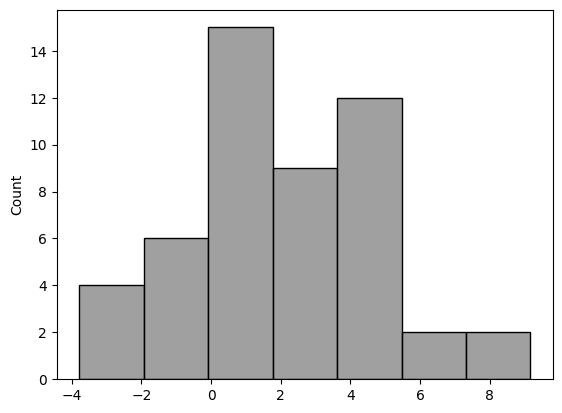

In [3]:
sns.histplot(y, color='gray')

In [10]:
### Create data dictionary
data_dict = {
    'y': y,
    'N': N
}

In [13]:
program_code = """

data {
    int<lower=1> N;
    vector[N] y;
}

parameters {
    real mu;
    real<lower=0> sigma2;
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma2);
}

model {
    // Priors
    mu ~ normal(0, 3);
    sigma2 ~ inv_gamma(1, 1);

    // Data model (likelihood)
    for (n in 1:N) {
        y[n] ~ normal(mu, sigma);
    }
}
"""

In [12]:
### Build model
model = stan.build(program_code, data=data_dict)

Building...



Building: 12.9s, done.

In [14]:
### Fit model
fit = model.sample(num_chains=4, num_samples=1000, num_warmup=500)

Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_gb4s_l96/model_as7suoal.stan', line 25, column 8 to column 33)
  If this warning occurs sporadically, such a

In [15]:
### Explore raw model outouts
results_df = fit.to_frame()

In [16]:
results_df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma2,sigma
draws,,,,,,,,,,
0,-80.281594,1.000000,0.907837,2.0,3.0,0.0,80.930727,2.090041,8.116244,2.848902
1,-80.660507,0.987695,0.859888,3.0,7.0,0.0,81.292773,2.408951,7.287441,2.699526
2,-81.121795,0.963145,0.825808,2.0,7.0,0.0,82.034702,1.646257,9.119247,3.019809
3,-82.812812,0.930004,0.759618,2.0,3.0,0.0,83.266978,1.660105,12.321465,3.510194
4,-81.608271,0.744911,0.907837,1.0,3.0,0.0,82.374513,1.855336,10.969428,3.312013


In [17]:
results_df.shape

(4000, 10)

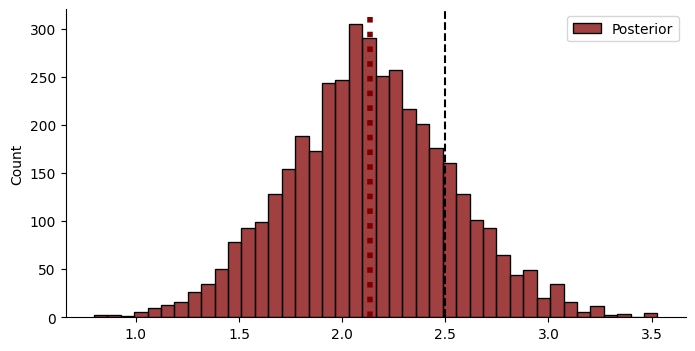

In [26]:
prior_samples = np.random.normal(0, 3, size=4000)
post_samples = results_df.mu.values
f, ax = plt.subplots(1, 1, figsize=(8, 4))
# sns.histplot(prior_samples, ax=ax, color="gray", alpha=0.8, label="Prior")
sns.histplot(post_samples, color='maroon', ax=ax, label="Posterior")
ax.axvline(np.mean(post_samples), color="maroon", linestyle="dotted", lw=4)
ax.axvline(mu, color="black", linestyle="dashed")
sns.despine(ax=ax)
ax.legend()

In [27]:
### Summarize model
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,2.134,0.399,1.417,2.927,0.007,0.005,3030.0,2335.0,1.0
sigma2,8.441,1.757,5.503,11.727,0.032,0.023,3132.0,2363.0,1.0
sigma,2.890,0.296,2.359,3.435,0.005,0.004,3132.0,2363.0,1.0


/home/radevs/anaconda3/envs/cognitive/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


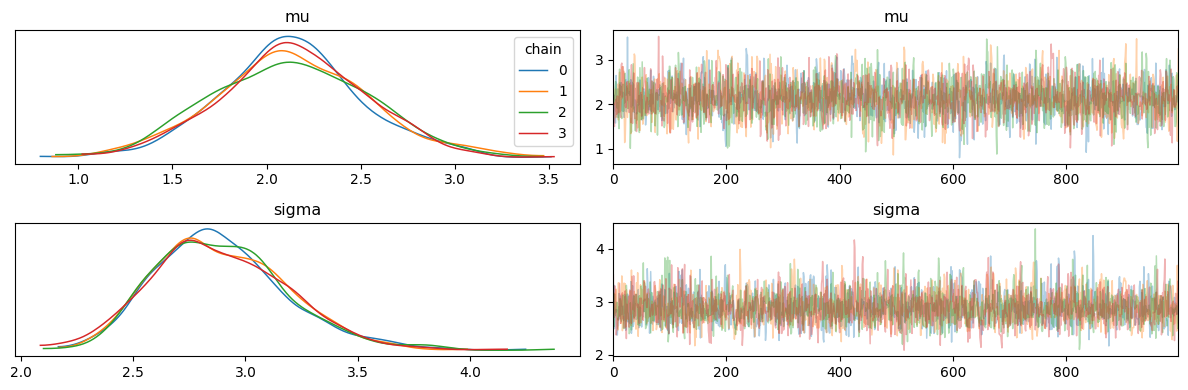

In [28]:
### Visual inspection and diagnostics
az.plot_trace(fit, var_names=['mu', 'sigma'], compact=False, legend=True)
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

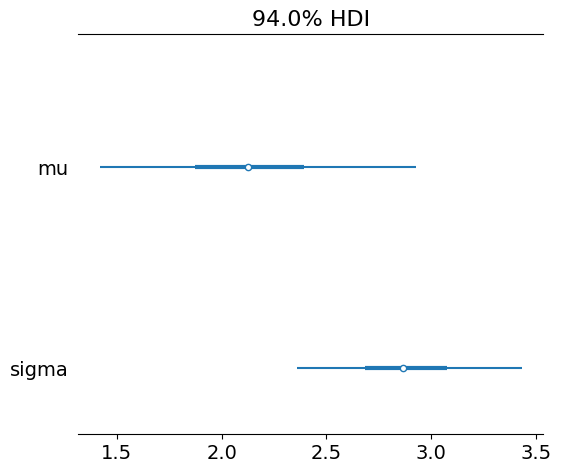

In [29]:
### Forest plots
az.plot_forest(fit, var_names=['mu', 'sigma'], combined=True)

Text(0, 0.5, '$\\sigma$')

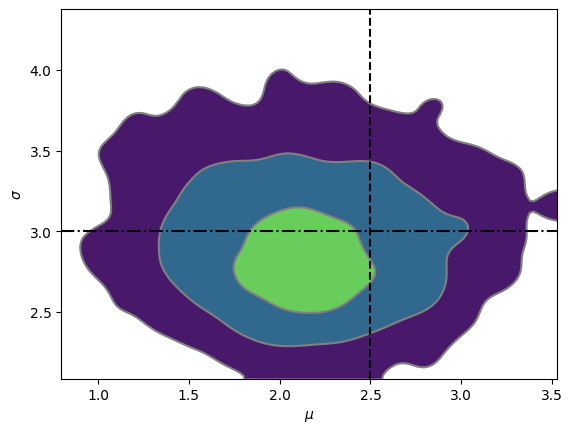

In [31]:
### Plot KDEs
ax = az.plot_kde(results_df.mu, 
                 results_df.sigma, hdi_probs=[0.393, 0.86, 0.99])
ax.axvline(mu, color='black', linestyle='--')
ax.axhline(sigma, color='black', linestyle='-.')
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\sigma$")

## Bayesian regression model

Next, we will build a simple Bayesian regression model of the form:
$$
\begin{align}
    \nonumber \sigma^2 &\sim \text{Inv-Gamma}(1, 1)\\
    \nonumber \alpha &\sim \mathcal{N}(0, 5)\\
    \nonumber \beta &\sim \mathcal{N}(0, 5)\\
\nonumber y_n &\sim \mathcal{N}(\alpha + \beta\,x_n, \sigma^2) \quad \text{for} \,\, n = 1,\dots,N
\end{align}
$$

In [ ]:
#### Your code here